# 1. 引言
前面几个章节我们都是在讲模型各个组件如何构造，每个组件背后的技术原理及其在整个模型中所起的作用，包括分词器、自注意力、LLM架构等。

从本节开始，我们会进入训练部分，开始关注如何对模型进行训练。在训练模型之前，我们需要先构造数据集，那预训练需要什么样的数据呢？

# 2. 预训练需要什么数据？
预训练任务的目的是让GPT模型学会预测下一个词，具体来讲，是通过观察句子中前面的词来学习预测下一个即将出现的词（如下图所示）。

> 预测下一个词这种方法帮助模型理解词语和短语在语言中通常是如何组合在一起的，从而提升了其对上下文的把握能力，使得生成的文本更加自然流畅与符合语法规则。

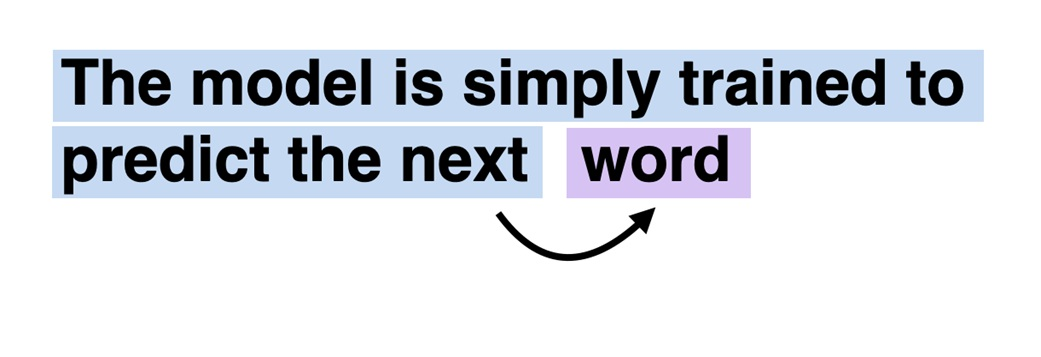
这是一种自我标记的数据，可以使用句子中下一个词作为模型应该预测的标签，这类标签可以在训练过程中即时创建。这意味着我们不需要为训练数据显式的收集标签，可以直接利用大量未标记的文本数据集，来训练大型语言模型。

所以，预训练数据的输入应该是一串文本，预期输出应该是next token。那我们的任务就是把所有输入数据改造成文本串和next token两两映射的输入-目标(input-target)对，如下图所示。
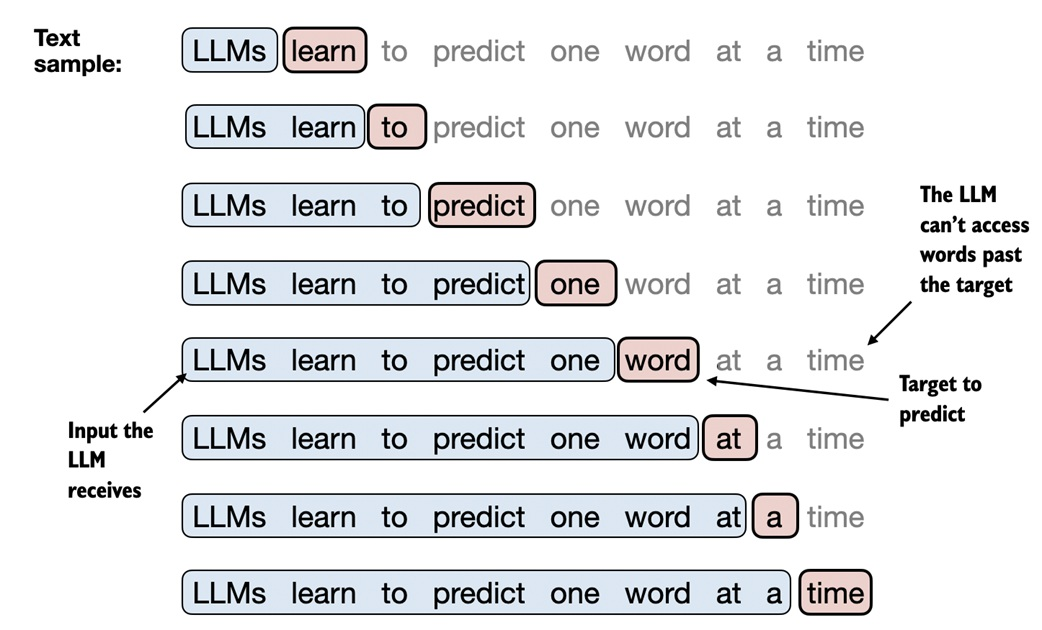
给定一个文本，我们需要从中提取输入子文本串，LLM的任务是预测输入子串之后的下一个token。

# 3.基于滑动窗口的数据采样
我们知道，模型的上下文窗口都是有长度限制的，因此我们需要对文本进行采样，以生成符合长度要求的输入-目标对。

下面我们将以存放在text变量的文本串为例，详细来绍数据采样的过程（为方便演示，将上下文窗口的长度设置为4）。

In [19]:
context_length = 4
text = "In the heart of the city stood the old library, a relic from a bygone era. Its stone walls bore the marks of time, and ivy clung tightly to its facade ..."

使用之前训练好的分词器对文本进行序列化。

In [20]:
from transformers import AutoTokenizer

tokenizer_path = "./tokenizer/"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

token_ids = tokenizer.encode(text)
print('token_ids num:', len(token_ids))
print(token_ids)

token_ids num: 137
[43, 80, 223, 86, 74, 71, 223, 74, 71, 10469, 86, 223, 81, 72, 223, 86, 74, 71, 223, 69, 14600, 91, 223, 85, 86, 81, 81, 70, 223, 86, 74, 71, 223, 81, 78, 70, 223, 23806, 29948, 10469, 91, 14, 223, 67, 223, 84, 20999, 75, 69, 223, 72, 84, 9162, 223, 67, 223, 68, 91, 73, 5574, 71, 223, 13757, 67, 16, 223, 43, 86, 85, 223, 85, 86, 5574, 71, 223, 89, 67, 78, 78, 85, 223, 68, 15761, 71, 223, 86, 74, 71, 223, 79, 10469, 77, 85, 223, 81, 72, 223, 86, 29684, 71, 14, 223, 12956, 70, 223, 75, 88, 91, 223, 69, 78, 87, 80, 73, 223, 86, 75, 73, 74, 86, 78, 91, 223, 86, 81, 223, 14600, 85, 223, 72, 67, 69, 67, 70, 71, 223, 4740]


In [21]:
tokenizer.decode(token_ids[:30])

'In the heart of the city stood t'

创建预训练任务需要的输入-目标对时，我们用两个变量x、y分别表示输入token序列和目标token序列，目标序列是由输入序列中每个token向右移动一个位置构成。

In [22]:
x = token_ids[0:context_length]
y = token_ids[1:context_length+1]
print('x:',x)
print('y:', y)

x: [43, 80, 223, 86]
y: [80, 223, 86, 74]


> 上面的x、y就组成了一条预训练数据，x 是模型接收到的输入序列，y 是预期的模型输出序列，也就是LLM要完成的预测任务。

如果按照context_length的长度继续向右滑动，每次滑动一个单位，我们还可以构建更多的预测任务。

In [23]:
for i in range(context_length+1):
    x = token_ids[i:context_length+i]
    y = token_ids[i+1:context_length+i+1]
    print(f"{x} ---> {y}")

[43, 80, 223, 86] ---> [80, 223, 86, 74]
[80, 223, 86, 74] ---> [223, 86, 74, 71]
[223, 86, 74, 71] ---> [86, 74, 71, 223]
[86, 74, 71, 223] ---> [74, 71, 223, 74]
[74, 71, 223, 74] ---> [71, 223, 74, 71]


也可以把这些token_id用文本来表示。

In [24]:
for i in range(context_length+1):
    x = token_ids[i:context_length+i]
    y = token_ids[i+1:context_length+i+1]
    print(f"{tokenizer.decode(x)} ---> {tokenizer.decode(y)}")

In t ---> n th
n th --->  the
 the ---> the 
the  ---> he h
he h ---> e he


> 注：-->左边内容是LLM接收到的输入序列x，-->右边内容是LLM应该预测的输出序列y。

但是这些训练数据之间有很多数据重叠（例如：第一个输入序列In the heart of后三个token和第二个输入序列the heart of the的前三个token相同），会导致模型进行很多重复的推理和损失计算。为了避免重叠，可以将滑动步长设为context_length.

In [25]:
for i in range(0,context_length*5,context_length):
    x = token_ids[i: i + context_length]
    y = token_ids[i+1: i+context_length+1]
    print(f"{tokenizer.decode(x)} --> {tokenizer.decode(y)}")

In t --> n th
he h --> e he
eart  --> art o
of t --> f th
he c --> e cit


这个构建输入-目标对的过程就是一个长度为context_length的窗口不断向右滑动的过程（如下图所示），因此类似这样的数据采样过程被称为基于滑动窗口的数据采样。 
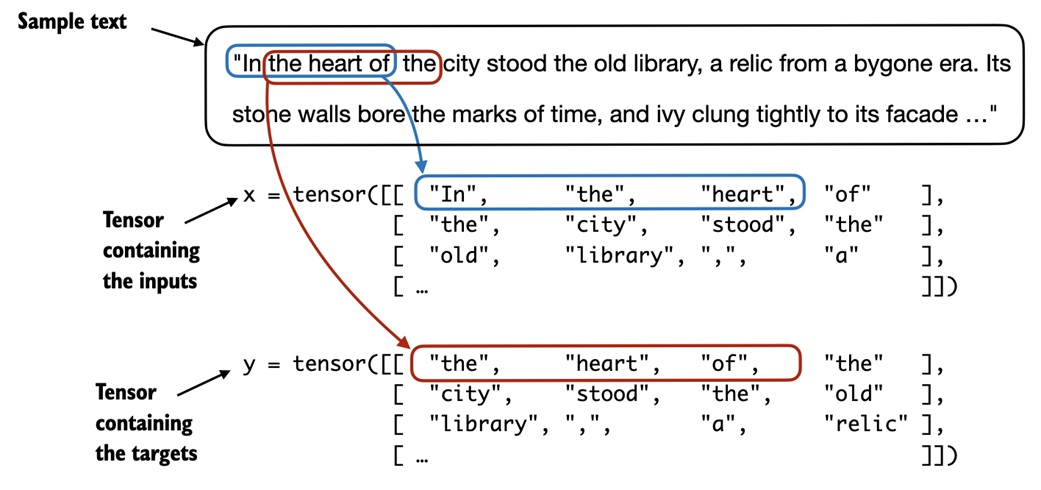

# 4.数据集加载
## 4.1 数据集读取
先查看一下我们将要使用的预训练数据集。

这个数据集达到33GB，一般的机器内存都无法一次性加载，所以这里在读取数据时引入yield生成器模式来迭代返回小批量数据集，通过max_size参数来指定一次迭代的批量数据大小（字符为单位）。

> 注：数据集是一个jsonl格式的文本文件，每一行是一条json格式的数据，文本内容放在text字段中。

In [ ]:
import json

def read_text_dataset(data_path, max_size=100*1024*1024):
    with open(data_path, 'r', encoding='utf-8') as f:
        current_size = 0
        current_texts = []
        ix = 0
        while True:
            ix += 1
            if ix >= 10000: continue
            line = f.readline()
            if not line:
                if current_texts:
                    yield current_texts
                break

            data = json.loads(line)
            current_texts.append(data['text'])
            current_size += len(data['text'])
            if current_size >= max_size:
                yield current_texts
                current_texts = []
                current_size = 0

pretrain_data_path = "./datasets/pretrain_hq.jsonl"
text_dataset = read_text_dataset(pretrain_data_path)

texts = next(text_dataset)
texts[0], len(texts)

## 4.2 数据集处理
为了给模型训练提供标准化的输入-输出数据对，我们需要封装一个数据集PretrainDataset。主要做以下几件事：

1. 文本序列化，将所有的文本都转换为token ID序列；
2. 滑动窗口采样，按照指定步长stride向右滑动，将token序列切分成一个个max_tokens长度的input序列；
3. 生成input-target数据对，每个输入序列的生成目标是序列之后的下一个token；
4. 标准化数据访问，实现__len__和__getitem__方法，兼容pytorch的DataLoader；

In [ ]:
tokenizer.unk_token

In [ ]:
import torch
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader


class PretrainDataset(Dataset):
    def __init__(self, texts, tokenizer, max_tokens, stride=-1, limit=-1):
        self.max_tokens = max_tokens
        self.stride = stride
        self.tokenizer = tokenizer
        sep = tokenizer.unk_token
        
        # 文章转换为tokenid，并使用padding token拼接到一起
        token_ids = tokenizer.encode(sep.join(texts) + sep)
        
        self.input_set = []
        self.target_set = []
        for j in range(0, len(token_ids) - self.max_tokens, self.stride):
            input_ids = token_ids[j: j + self.max_tokens]
            target_ids = token_ids[j+1: j + self.max_tokens + 1]
            self.input_set.append(input_ids)
            self.target_set.append(target_ids)
            if limit > 0 and len(self.input_set) >= limit:
                break
    
    
    def __len__(self):
        return len(self.input_set)
    
    def __getitem__(self, ix):
        return torch.tensor(self.input_set[ix]), torch.tensor(self.target_set[ix])

> 注：上面这个PretrainDataset是基于pytorch的Dataset类来构建，这个基类规定了如何从数据集中抽取单个样本。 注：separator是不同文本串之间的分隔符，目的是训练时帮助模型正确区分不同的文本数据，这里使用<|endoftext|>作为分隔符。

再基于pytorch提供的Dataloader类来构建数据加载器。

In [ ]:
import time

start_time = time.time()
context_length = 1024
ds1 = PretrainDataset(texts, tokenizer, context_length, context_length)
print("len(ds1):", len(ds1), ", use time: ", time.time()-start_time)
dataloader = DataLoader(ds1, batch_size=4, shuffle=True, drop_last=True)
data = next(iter(dataloader))
data

这样分段加载的数据集虽然解决了大数据量下的内存不足问题，但是在实际应用中还会存在两个问题：

1. 增加了数据访问的复杂性，整个数据集需要先分段加载，再在分段内构造Dataset进行双层循环迭代，并且无法有效预估整个训练的小批量迭代step数；
2. 一份数据通常都会反复训练多轮，每轮训练都需要对文本数据进行分词和序列化，而这个过程又恰恰比较消耗时间和计算资源，导致重复冗余计算；

# 5. 高效数据加载
针对上面的问题，有一种解决办法是将所有数据先一次性序列化为二进制格式，之后使用numpy的内存映射功能实现高效的数据加载。这种方式可以避免在内存中加载整个数据集，同时又保证了token序列化这种耗时耗资源的过程只会执行一次。

## 5.1 数据序列化
下面是数据预处理的函数texts_to_bin，接收jsonl数据路径作为输入目录、.bin文件路径作为输出目录，将所有文本经过序列化后拼接到一起，并转换为字节流写入二进制文件。

In [ ]:
import numpy as np
import json


def texts_to_bin(input_path, output_path, tokenizer, content_key="content"):
    bos_token = tokenizer.special_tokens_map['bos_token']
    eos_token = tokenizer.special_tokens_map['eos_token']
    max_buffered_length = 1 * 1024 * 1024
    ix = 0
    with open(input_path, "r", encoding="utf-8") as reader:
        with open(output_path, "wb") as writer:
            buffered_ids = []
            i = 0
            while True:
                ix += 1
                if ix >= 10000:break
                line = reader.readline()
                if not line:
                    break
                content = json.loads(line).get(content_key, "")
                if not content:
                    continue
                
                # 将数据序列化为二进制格式
                tokenized = tokenizer(bos_token + content + eos_token)
                buffered_ids += tokenized["input_ids"]
                if len(buffered_ids) >= max_buffered_length:
                    arr = np.array(buffered_ids, dtype=np.uint16)
                    writer.write(arr.tobytes())
                    buffered_ids.clear()
                    i += 1
                    print(f"write {i}m bytes") if i % 100 == 0 else None
            # 处理最后一段不满max_buffer_length的token序列
            if len(buffered_ids) > 0:
                arr = np.array(buffered_ids, dtype=np.uint16)
                writer.write(arr.tobytes())
                print(f"write arr: {len(arr)}")

In [ ]:
%%time 

input_path = "./datasets/pretrain_hq.jsonl"
output_path = "./datasets/pretrain_hq.bin"
texts_to_bin(input_path, output_path, tokenizer, content_key="text")

## 5.2 数据加载
这里会用到一个np.memmap技术，这是一种将文件映射到内存的技术，它允许用户像访问普通内存中的numpy数组一样访问磁盘上的整个数据集，但实际上只有少部分数据从磁盘加载到了内存中，这种技术非常适合处理大型数据集。

In [ ]:
class PretrainBinaryDataset(Dataset):
    def __init__(self, data_path, max_tokens):
        with open(data_path) as f:
            f.seek(0, 2)
            self.total_tokens = f.tell() // np.dtype("uint16").itemsize
            print(f"total_tokens: {self.total_tokens}")
        
        self.data = np.memmap(data_path, dtype=np.uint16, shape=(self.total_tokens//max_tokens, max_tokens))

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        assert isinstance(index, int)
        item = self.data[index]
        input = item[:-1].astype(np.int64)
        target = item[1:].astype(np.int64)  # 在计算交叉熵损失时要求目标输出为长整型
        return torch.from_numpy(input), torch.from_numpy(target)

部分代码释义如下：

- f.seek(0, 2):将文件的读取指针移动到文件的末尾（0表示从当前指针移动，2表示从文件末尾移动）;
- f.tell(): 返回当前读取指针的位置（即文件的总字节数），然后我们用字节数除以 np.dtype("uint16").itemsize 获取总tokens数，表示文件中可以读取的token数量;
- shape=(self.total_tokens//max_tokens, max_tokens): 将数据划分成多个样本，每个样本的大小为 max_tokens(即context_length)，样本的数量为 self.total_tokens // max_tokens。

测试高效数据加载类的加载速度：

In [ ]:
%%time

dataset_path = "./datasets/pretrain_hq.bin"
ds = PretrainBinaryDataset(dataset_path, context_length)
for i in range(74406):
    item = ds[i]
    pass